# Projekt zaliczeniowy - uczenie głębokie

Twoim zadaniem będzie wytrenowanie modelu, który będzie klasyfikował choroby oczu na podstawie zdjęć.

Dataset potrzebny do wykonania tego zadania znajduje się tutaj: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification (do pobrania zbioru wymagane będzie zalogowanie na stronie)

Możliwe klasy do rozpoznania to:
1. Oko normalne (zdrowe)
2. Retinopatia cukrzycowa (https://pl.wikipedia.org/wiki/Retinopatia_cukrzycowa)
3. Zaćma (https://pl.wikipedia.org/wiki/Za%C4%87ma)
4. Jaskra (https://pl.wikipedia.org/wiki/Jaskra)

Każda z klas zawiera około 1000 zdjęć.

Twój model powinien opierać się na wykorzystaniu sieci konwolucyjnej, bez wykorzystywania pretrenowanych modeli.

Kryteria oceny:
1. Wczytanie zbioru (1 pkt.)
2. Podział zbioru na treningowy i testowy (1 pkt.) - pamiętaj, żeby wszystkie klasy był dobrze zareprezentowane w obu zbiorach
3. Stworzenie dataloaderów (1 pkt.)
4. Stworzenie modelu sieci konwolucyjnej (1 pkt.)
5. Wytrenowanie modelu (1 pkt.)
6. Osiągnięcie performancu modelu na poziomie powyżej 85% (1 pkt.)
7. Stworzenie macierzy pomyłek dla każdej klasy (1 pkt.)
8. Wizualizacja przykładów na których model popełnił błąd (1 pkt.)
9. Raport z wykonanego zadania (2 pkt.)

Pamiętaj, żeby w czasie treningu eksperymentować z parametrami oraz architekturą sieci. Można robić augmentacje na zbiorze danych. Opisz swoje podejścia w raporcie, jak myślisz dlaczego niekótre próby były bardziej udane niż inne?

W razie pytań proszę o kontakt w wiadomości prywatnej.

Dopuszczalne są drobne modyfikacje w kodzie, np. użycie dodatkowych bibliotek, poprawa błędów (jeśli takie będą - proszę wtedy zawrzeć uzasadnienie takiej zmiany w raporcie).

Deadline na wysłania zadania: 27.01.2024 do końca dnia

Powodzenia!

Importy

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from sklearn.model_selection import train_test_split #dodane do podzielenia danych
# do macierzy pomylek
from sklearn.metrics import confusion_matrix
import seaborn as sns

Ustawienie urządzenia na którym sieć będzie trenowana

In [2]:
# cuda:0 = GPU, cpu = CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Wczytywanie danych

In [3]:
def load_data(data_dir):
    images = []
    labels = []
    classes = ['glaucoma', 'normal', 'diabetic_retinopathy', 'cataract']
    for label in classes:
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            images.append(img_path)
            labels.append(classes.index(label))
    return images, labels

data_dir = r'C:\deep_learnig\dataset' #ścieżka do folderu z danymi
images, labels = load_data(data_dir)

Dzielenie danych na zbiory treningowe i testowe

In [4]:
# trains set 80%
# test set 20%
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels)

trainset = list(zip(train_images, train_labels))
testset = list(zip(test_images, test_labels))

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

Normalizacja danych wejściowych i tworzenie CustomDatasetu

In [6]:
transform = transforms.Compose([
    transforms.Resize((256, 256)), # zmiana rozmiaru skanu do 256x256 bo niektóre są większe
    transforms.ToTensor(), # zamiana obrazu na tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalizacja obrazu
])


# stwórz obiekt Dataset dla każdego ze zbiorów, wykorzystaj do niego klasę CustomDataset
custom_trainset = CustomDataset(trainset, transform=transform)
custom_testset = CustomDataset(testset, transform=transform)

Ustawianie wielkości batcha

In [7]:
batch_size = 20
# 4 = max 86% accuracy
# 10 = max 87% accuracy
# 15 = max 88% accuracy
# 20 = max 89% accuracy

Tworzenie dataloaderów 

In [8]:
trainloader = torch.utils.data.DataLoader(custom_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0, drop_last=True)

testloader = torch.utils.data.DataLoader(custom_testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0) # num workers zmienione na 0 bo lokalnie nie działało

Tworzenie sieci neuronowej

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Pierwsza warstwa konwolucyjna
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)  # Zmniejszenie rozmiaru o połowę

        # Druga warstwa konwolucyjna
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Trzecia warstwa konwolucyjna
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Czwarta warstwa konwolucyjna
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        # Pooling zmniejszający rozmiar o połowę, zastosowany dwukrotnie
        self.pool2 = nn.MaxPool2d(2, 2)  # To samo co self.pool

        # Warstwy w pełni połączone
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 4)
        
        self.dropout = nn.Dropout(0.5) 

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 128x128
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 64x64
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 32x32
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # 16x16
      
        # Spłaszczanie obrazu do wektora
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.bn5(self.fc1(x))))
        x = self.fc2(x)
        return x

Przygotowanie treningu modelu

In [10]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5) 
# optimizer = optim.Adam(net.parameters(), lr=0.001) # nic sie nie zmienia xxd
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.1)
num_epoch = 20 # Liczba cykli

Rozpoczęcie trenowania modelu

In [11]:
print('Starting...')

for epoch in range(num_epoch):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)    
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:    # wypisz statystyki co 100 mini-batchy
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct // total
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch ({epoch + 1}/{num_epoch}) | net accuracy: {accuracy}% | curr_lr: {current_lr}' )

    # zmiana learning rate w zależności od dokładności
    scheduler.step(accuracy)
    
    net.train()
    
print('Finished')

Starting...
[1,   100] loss: 0.828
Epoch (1/20) | net accuracy: 80% | curr_lr: 0.001
[2,   100] loss: 0.527
Epoch (2/20) | net accuracy: 78% | curr_lr: 0.001
[3,   100] loss: 0.471
Epoch (3/20) | net accuracy: 77% | curr_lr: 0.001
[4,   100] loss: 0.382
Epoch (4/20) | net accuracy: 82% | curr_lr: 0.001
[5,   100] loss: 0.376
Epoch (5/20) | net accuracy: 85% | curr_lr: 0.001
[6,   100] loss: 0.359
Epoch (6/20) | net accuracy: 85% | curr_lr: 0.001
[7,   100] loss: 0.328
Epoch (7/20) | net accuracy: 86% | curr_lr: 0.001
[8,   100] loss: 0.268
Epoch (8/20) | net accuracy: 86% | curr_lr: 0.001
[9,   100] loss: 0.233
Epoch (9/20) | net accuracy: 86% | curr_lr: 0.001
[10,   100] loss: 0.236
Epoch (10/20) | net accuracy: 84% | curr_lr: 0.001
[11,   100] loss: 0.189
Epoch (11/20) | net accuracy: 88% | curr_lr: 0.0001
[12,   100] loss: 0.159
Epoch (12/20) | net accuracy: 88% | curr_lr: 0.0001
[13,   100] loss: 0.137
Epoch (13/20) | net accuracy: 88% | curr_lr: 0.0001
[14,   100] loss: 0.133
Epoc

Przechwycenie etykiet i przewidywań

In [12]:
classes = ('glaucoma', 'normal', 'diabetic_retinopathy', 'cataract')
all_labels = []
all_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

Obliczanie macierzy pomyłek

In [13]:
conf_matrix = confusion_matrix(all_labels, all_preds)

Wizualizacja macierzy pomyłek

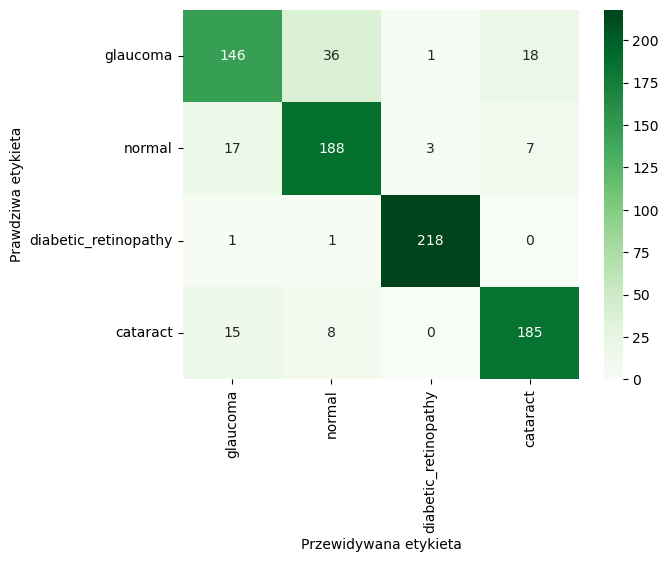

In [14]:

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.xlabel('Przewidywana etykieta')
plt.ylabel('Prawdziwa etykieta')
plt.show()

Zmiana modelu na tryb eval żeby dane nie były zaburzone przez dropout i batchnorm

In [15]:
net.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

Wyświetalnie 5 błędnie sklasyfikowanych skanów oka

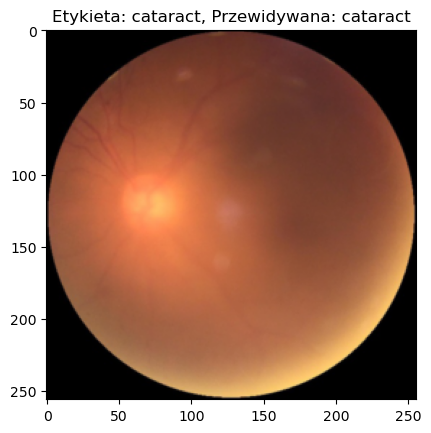

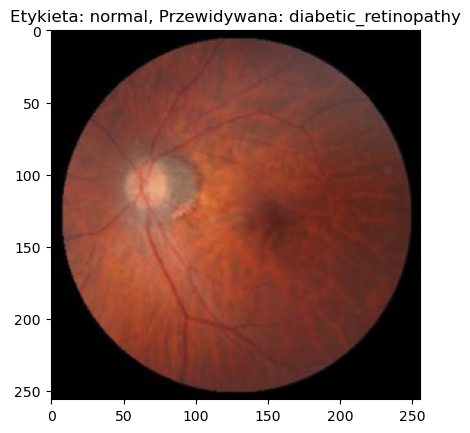

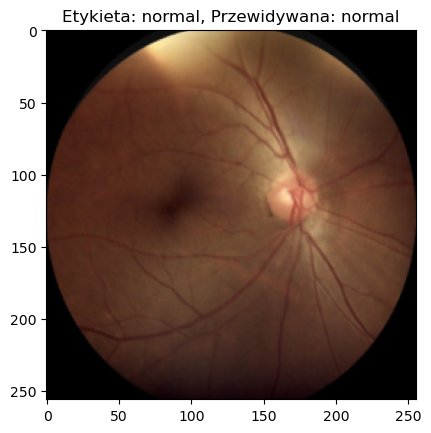

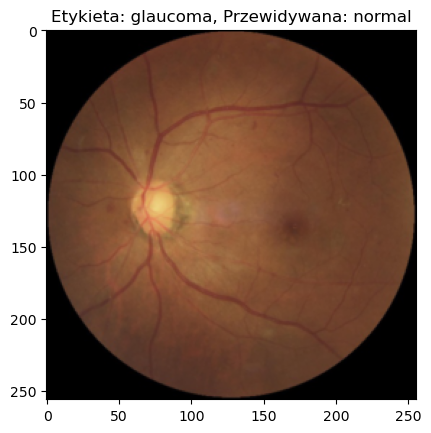

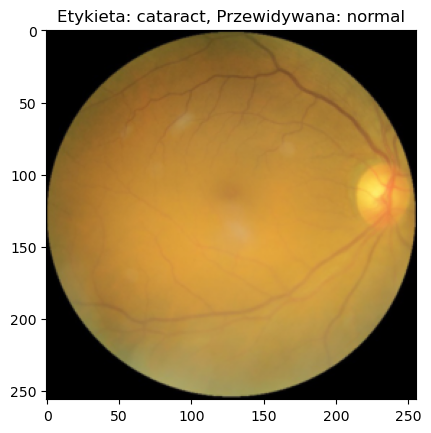

In [16]:
misclassified_samples = [(idx, pred) for idx, (true, pred) in enumerate(zip(all_labels, all_preds)) if true != pred]
for i, (idx, pred_label) in enumerate(misclassified_samples[:5]):
    image_path, true_label = testset[idx]
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        _, pred_label = torch.max(net(image_tensor), 1)
        pred_label = pred_label.item()

    image_show = image_tensor.squeeze(0).cpu().detach().permute(1, 2, 0).numpy()
    image_show = image_show * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image_show = np.clip(image_show, 0, 1)

    plt.imshow(image_show)
    plt.title(f"Etykieta: {classes[true_label]}, Przewidywana: {classes[pred_label]}")
    plt.show()


# Raport

Autor: Wojciech Derlikiewicz

indeks: 38053

**Celem projektu zaliczeniowego** jest stworzenie sieci konwolucyjnej, która efektywnie rozpoznaje przypadłości oczu (zdrowe oczy, retinopatia cukrzycowa, zaćma i jaskra) na podstawie ich skanu z dokładnością powyżej 85% skuteczności.

### Metodologia
Wczytanie i Przetwarzanie Danych:
Dane zostały wczytane i przetworzone, gdzie zdjęcia zostały przeskalowane do rozmiaru 256x256 (wybrałem najmniejszy rozmiar skanu z dostępnych danych), zamienione na tensory i znormalizowane. Zbiór danych podzielono na zbiory treningowy (80%) i testowy (20%), z zachowaniem równomiernego rozkładu klas.

### Architektura Modelu
Stworzono model z czterema warstwami konwolucyjnymi, z normalizacją wsadową (batch normalization) i warstwami w pełni połączonymi. Zastosowano Dropout z prawdopodobieństwem 0.5, aby zapobiegać przeuczeniu. Rozmiar batcha eksperymentalnie ustalono na 20.

### Trenowanie Modelu
Model trenowano przez 20 epok, wykorzystując funkcję straty CrossEntropyLoss i optymalizator SGD z początkowym tempem uczenia 0.001 i weight decay ustawionym na 1e-5. Zastosowano scheduler do adaptacyjnej zmiany tempa uczenia w zależności od dokładności.

### Wyniki
Model osiągnął maksymalną dokładność na poziomie 90% na zbiorze testowym. Zaobserwowano, że zwiększenie batch_size z 10 na 15 obniżyło wartość funkcji straty o około 0.200. Dodanie Dropoutu oraz dodatkowej warstwy konwolucyjnej (do czterech) umożliwiło osiągnięcie stabilniejszej dokładności na poziomie około 89%.

### Analiza Wyników i Spostrzeżenia
**Wpływ Batch Size:** Zwiększenie batch_size przyczyniło się do szybszego spadku wartości funkcji straty na wczesnych etapach treningu, co sugeruje lepsze wykorzystanie zasobów obliczeniowych.

**Eksperymentowanie z ilością wartw w sieci:** Edytowanie sieci do 6 warstw wpłyneło na znacznie wyższe wkorzystanie zasobów gpu, pamięci oraz znacznie zwiększając czas treningu, nie przynosząc żadych innych wyników w dokładności modelu. 

**Regularyzacja:** Użycie Dropoutu i weight decay pomogło w regulacji modelu, ograniczając przeuczenie.

**Optymalizacja Tempa Uczenia:** Stosowanie scheduler'a do adaptacyjnej zmiany tempa uczenia nie przyniosło znaczącej poprawy dokładności, ale mogło przyczynić się do stabilniejszego procesu uczenia.

### Wnioski
Model zastosowany w projekcie skutecznie klasyfikuje choroby oczu, osiągając zadawalającą dokładność. Eksperymenty z rozmiarem batcha, regularyzacją i optymalizacją tempa uczenia wykazały, że drobne modyfikacje mogą mieć znaczący wpływ na wydajność modelu.